# BCI Project

In [196]:
import numpy as np
import pywt
import math
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, closing, opening, area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from skimage.metrics import mean_squared_error as MSE, peak_signal_noise_ratio as PSNR, structural_similarity as SSIM
from skimage.util import random_noise
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import json
from scipy.fftpack import dct, idct

# Step wise

## Reading Image

255

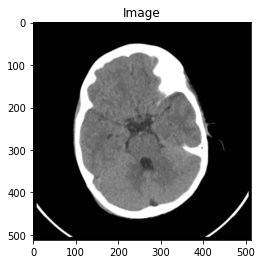

In [306]:
img = imread(f'./images/brain.png')
fig, ax = plt.subplots(1,1)
ax.set_title("Image")
ax.imshow(img,cmap="gray")
img.max()

## Thresholding

We use OTSU algorithm to determine the threshold value

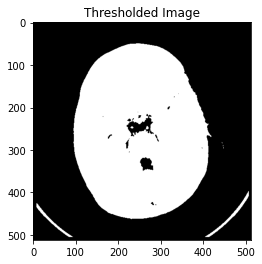

In [307]:
threshold = threshold_otsu(img)
result = (img > threshold)
fig, ax = plt.subplots(1,1)
ax.set_title("Thresholded Image")
ax.imshow(result,cmap="gray")

> We will be using connected regions algorithm for extracting the ROI, for that we will have to cleanup the thresholded image. In the image below we are applying morphological operations such as sucessive `dilation` to close the pixels, `area_closing` to fill the holes (ventricles) in the brain and successive `erosion` to restore the original shape and `opening` to remove noise from the image.

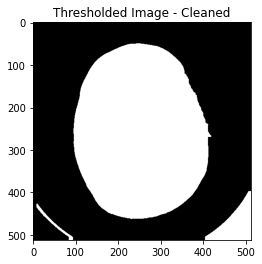

In [308]:
square = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])

def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im

def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im

multi_dilated = multi_dil(result, 7)
area_closed = area_closing(multi_dilated, 50000)
multi_eroded = multi_ero(area_closed, 7)
opened = opening(multi_eroded)
fig, ax = plt.subplots(1,1)
ax.set_title("Thresholded Image - Cleaned")
ax.imshow(opened,cmap="gray")

## Extracting ROI Features

We use the `label` function to label the regions of the image and find some of the properties of that region such as, area, perimeter, solidity, eccentricty, bounding box area and area ratio.

In [309]:
label_im = label(opened)
regions = regionprops(label_im)
properties = ['area','bbox_area',
              'solidity', 'eccentricity','perimeter']
table = pd.DataFrame(regionprops_table(label_im, result, properties=properties))
table["area_ratio"] = table["area"] / table["bbox_area"]
table

,area,bbox_area,solidity,eccentricity,perimeter,area_ratio
0,103555,133812,0.989366,0.653620,1242.271211,0.773884
1,5985,12420,0.865510,0.838407,388.693434,0.481884
2,725,7396,0.583736,0.997798,257.404112,0.098026


## ROI Extraction

We select the region with the maximum area and use the bbox attribute the pixel locations of the bounding box of that region and extract that region from the original image

(413, 324)


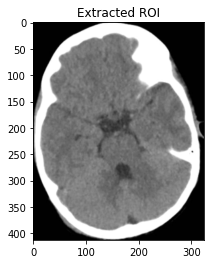

In [310]:
index = table["area"].idxmax()
box = regions[index].bbox
ROI = img[box[0]:box[2], box[1]:box[3]]
fig, ax = plt.subplots(1,1)
print(ROI.shape)
ax.set_title("Extracted ROI")
ax.imshow(ROI,cmap="gray")

## ROI Watermark Generation

We use the extracted features from the ROI and write it on an image with a dynamic size i.e 1/4th of the ROI size, since we will be embedding the Watermark in the LL2 region of the DWT transform of the ROI.

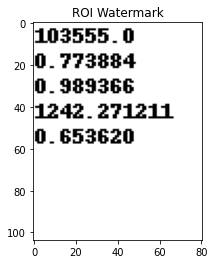

In [311]:
area = table.iloc[index].area
area_ratio = table.iloc[index].area_ratio
solidity = table.iloc[index].solidity
perimeter = table.iloc[index].perimeter
eccentricity = table.iloc[index].eccentricity

area_ratio_str = "{:.6f}".format(area_ratio)
solidity_str = "{:.6f}".format(solidity)
perimeter_str = "{:.6f}".format(perimeter)
eccentricity_str = "{:.6f}".format(eccentricity)

height, width = ROI.shape
ROI_watermark_text = f"{area}\n{area_ratio_str}\n{solidity_str}\n{perimeter_str}\n{eccentricity_str}"

ROI_watermark = Image.new("RGB",(math.ceil(width/4),math.ceil(height/4)),color=(255,255,255))
ROI_watermark_draw = ImageDraw.Draw(ROI_watermark)
ROI_watermark_draw.multiline_text((1,1),ROI_watermark_text,spacing=1,fill=(0,0,0))
ROI_watermark_array = np.asarray(ROI_watermark)
ROI_watermark = rgb2gray(ROI_watermark_array)

fig, ax = plt.subplots(1,1)
ax.set_title("ROI Watermark")
ax.imshow(ROI_watermark,cmap="gray")

## ROI Watermark Encryption

We will be using Logistic Map encryption for encrypting our ROI watermark. The logistic map uses a pseudo random sequence generated using the following formula:
<html><body><p>X<sub>n+1</sub> = μX<sub>n</sub>(1 - X<sub>n</sub>)</p></body></html>
<html><body><p>We will be using the value of X<sub>n</sub> as 0.9 and μ as 3.95</p></body></html>

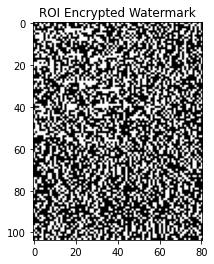

In [312]:
def logistic_encryption(watermark):
    row, col = watermark.shape
    N = row * col
    x = 0.9 + np.zeros(N)
    r = 3.95
    for n in range(N-1):
        x[n+1] = r * x[n] * (1 - x[n])
    x = x.reshape(row, col)
    boolean_x = np.around(x).astype("int")
    watermark = watermark.astype("int")
    encrypted_watermark = np.bitwise_xor(watermark, boolean_x).astype("float")
    return encrypted_watermark, boolean_x

ROI_encrypted_watermark, boolean_x = logistic_encryption(ROI_watermark)
fig, ax = plt.subplots(1,1)
ax.set_title("ROI Encrypted Watermark")
ax.imshow(ROI_encrypted_watermark,cmap="gray")

## ROI Watermark Emedding

In [313]:
model = "haar"
k = 8
def process_coefficients(imArray, model, level):
    coeffs=pywt.wavedec2(data = imArray, wavelet = model, level = level)
    coeffs_H=(coeffs)
    return coeffs_H

def quantization_step(LH2, HL2, HH2, k):
    LH2 = np.absolute(LH2).sum()
    HL2 = np.absolute(HL2).sum()
    HH2 = np.absolute(HH2).sum()
    return k * round(math.log((LH2 + HL2 + HH2) / 2))

def DWT(ROI, model, level, k):
    coeffs_image = process_coefficients(ROI, model, level=level)
    LL2 , (LH2, HL2, HH2), (LH1, HL1, HH1) = coeffs_image
    Q = quantization_step(LH2, HL2, HH2, k)
    Xq = LL2 / Q
    return Xq, (LH2, HL2, HH2), (LH1, HL1, HH1), Q

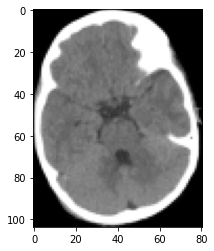

In [314]:
Xq, (LH2, HL2, HH2), (LH1, HL1, HH1), Q = DWT(ROI, model, 2, k)
plt.imshow(Xq,cmap="gray")

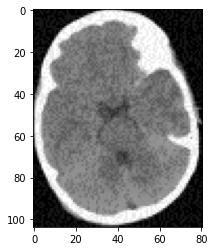

In [315]:
Xq_copy = Xq.copy()
row, col = Xq_copy.shape
for i in range(row):
    for j in range(col):
        if(round(Xq[i,j]%2) == ROI_encrypted_watermark[i,j]):
            Xq_copy[i,j] = Xq[i,j] * Q
        else:
            Xq_copy[i,j] = (Xq[i,j] * Q) + Q

plt.imshow(Xq_copy, cmap="gray")

## Reconstruction

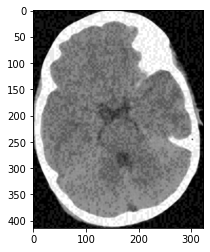

In [316]:
coeffs = [Xq_copy, (LH2,HL2, HH2), (LH1, HL1, HH1)]
image = pywt.waverec2(coeffs, model)
image = np.absolute(image)
plt.imshow(image, cmap="gray")

## ROI Watermark Extraction

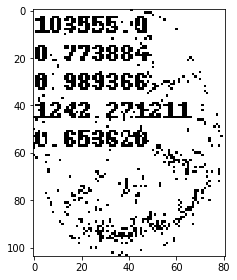

In [317]:
def extract_ROI_watermark(image,boolean_x):
    Zq, (LH2, HL2, HH2), (LH1, HL1, HH1), Q = DWT(image, model, 2, 8)
    Zq = np.round(Zq)
    Wsroi = Zq%2
    Wroi_salt = Wsroi.copy().astype("int")^boolean_x
    return Wroi_salt.astype("float")

extracted_ROI_watermark = extract_ROI_watermark(image,boolean_x)
imshow(extracted_ROI_watermark)

## RONI Extraction

(512, 64)

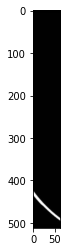

In [319]:
with open("./images/brain.json","r") as file:
    coords = json.load(file)
box = coords["RONI"]
RONI = img[box["0"]:box["2"], box["1"]:box["3"]]
plt.imshow(RONI, cmap="gray")
RONI.shape

# RONI Watermark Generation

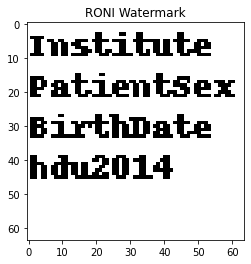

In [242]:
RONI_watermark = Image.new("RGB",(64,64),color=(255,255,255))
RONI_watermark_text = f"Institute\nPatientSex\nBirthDate\nhdu2014"
RONI_watermark_draw = ImageDraw.Draw(RONI_watermark)
RONI_watermark_draw.multiline_text((1,1),RONI_watermark_text,spacing=1,fill=(0,0,0))
RONI_watermark_array = np.asarray(RONI_watermark)
RONI_watermark = rgb2gray(RONI_watermark_array)
fig, ax = plt.subplots(1,1)
ax.set_title("RONI Watermark")
ax.imshow(RONI_watermark,cmap="gray")

## RONI Watermark Encryption

We will be using Arnold Transform for encrypting the RONI watermark. Arnold Transform changes the position of two pixels, and if it is applied several times, a disordered image can be generated.

(x' y') = (1 1; 1 2)(x y)modH

where x and y are the coordinates of the pixel, H is the height or width of the square image that is processed, and x′ and y′ are the coordinates of the scrambled image.

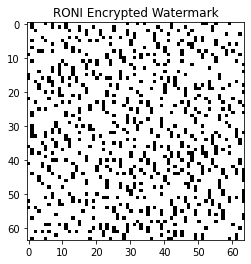

In [243]:
def arnold_transform(watermark):
    A = np.array([[1,1],[1,2]])
    watermark_copy = watermark
    N = 10
    for n in range(0,N):
        watermark_final = np.zeros(watermark_copy.shape)
        for i in range(watermark_copy.shape[0]):
            for j in range(watermark_copy.shape[1]):
                x = np.array([[i],[j]])
                y = np.matmul(A,x) % watermark_copy.shape[0]
                watermark_final[y[0][0], y[1][0]] = watermark_copy[i,j]
        watermark_copy = watermark_final
    return watermark_final, N

RONI_encrypted_watermark, N = arnold_transform(RONI_watermark)
fig, ax = plt.subplots(1,1)
ax.set_title("RONI Encrypted Watermark")
ax.imshow(RONI_encrypted_watermark,cmap="gray")

## ROI Watermark Decryption

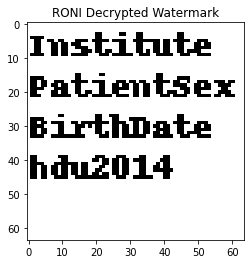

In [244]:
def arnold_transform_reverse(watermark, N):
    A = np.array([[2,-1],[-1,1]])
    watermark_final = watermark
    for n in range(0,N):
        watermark_copy = np.zeros(watermark_final.shape)
        for i in range(watermark_copy.shape[0]):
            for j in range(watermark_copy.shape[1]):
                x = np.array([[i],[j]])
                y = np.matmul(A,x) % watermark_copy.shape[0]
                watermark_copy[y[0][0], y[1][0]] = watermark_final[i,j]
        watermark_final = watermark_copy
    return watermark_final
        
RONI_decrypted_watermark = arnold_transform_reverse(RONI_encrypted_watermark, N)
fig, ax = plt.subplots(1,1)
ax.set_title("RONI Decrypted Watermark")
ax.imshow(RONI_decrypted_watermark,cmap="gray")

## RONI Watermark Embedding

We start the process by dividing the RONI into non-overlapping 8x8 blocks.

In [245]:
def extract_blocks(RONI):
    block_size=8
    i = 0
    RONI_blocks = np.empty((int(RONI.shape[0]/8), int( RONI.shape[1]/8), 8, 8), dtype="uint8")
    for r in range(0,RONI.shape[0], block_size):
        for c in range(0,RONI.shape[1], block_size):
            window = RONI[r:r+block_size ,c:c+block_size]
            RONI_blocks[int(r/8),int(c/8)] = window
    return RONI_blocks

In [246]:
RONI_blocks = extract_blocks(RONI)
print(f"Shape : {RONI_blocks.shape}")
RONI_blocks[0,0]

Shape : (64, 8, 8, 8)


array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

In [247]:
def reconstruct_blocks(RONI_blocks):
    block_size=8
    reconstructed_RONI = np.empty((RONI_blocks.shape[0]*8,RONI_blocks.shape[1]*8))
    for r in range(0,RONI.shape[0], block_size):
        for c in range(0,RONI.shape[1], block_size):
            reconstructed_RONI[r:r+block_size ,c:c+block_size] = RONI_blocks[int(r/8),int(c/8)]
    return reconstructed_RONI

def zigzag(n):
    '''zigzag rows'''
    def compare(xy):
        x, y = xy
        return (x + y, -y if (x + y) % 2 else y)
    xs = range(n)
    return {index: n for n, index in enumerate(sorted(
        ((x, y) for x in xs for y in xs),
        key=compare
    ))}

def embed_RONI_watermark(img,zigzag_pattern,watermark_bits):
    DCT = dct(img,norm="ortho")
    zigzag_dct = np.empty(64)
    Q = 4
    for i in range(0,64):
        zigzag_dct[i] = DCT[zigzag_pattern[i][0], zigzag_pattern[i][1]]
    middle_frequency = zigzag_dct[12:20]
    middle_frequency = np.round(middle_frequency / Q)
    embedded_frequency = np.empty(len(middle_frequency))
    for i in range(len(middle_frequency)):
        if((middle_frequency[i] + watermark_bits[i])%2 == 0):
            embedded_frequency[i] = (middle_frequency[i] + 0.5)*Q
        elif((middle_frequency[i] + watermark_bits[i])%2 == 1):
            embedded_frequency[i] = (middle_frequency[i] - 0.5)*Q
    zigzag_dct[12:20] = embedded_frequency
    inverse_zigzag = np.empty((8,8))
    for i in range(0,64):
        inverse_zigzag[zigzag_pattern[i][0],zigzag_pattern[i][1]] = zigzag_dct[i]
    return np.round(np.absolute(idct(inverse_zigzag)))

def embed_RONI(RONI_blocks,RONI_encrypted_watermark):
    watermark_bit_count = 0
    watermark = RONI_encrypted_watermark.copy().flatten()
    zigzag_pattern = list(zigzag(8).keys())
    embedded_RONI_blocks = np.empty(RONI_blocks.shape)
    for i in range(0,RONI_blocks.shape[0]):
        for j in range(0,RONI_blocks.shape[1]):
            watermark_bits = watermark[watermark_bit_count:watermark_bit_count+8]
            embedded_RONI_blocks[i,j] = embed_RONI_watermark(RONI_blocks[i,j],zigzag_pattern,watermark_bits)
            watermark_bit_count+=8
    return embedded_RONI_blocks

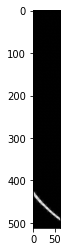

In [248]:
embedded_RONI_blocks = embed_RONI(RONI_blocks,RONI_encrypted_watermark)
reconstrcuted_RONI = reconstruct_blocks(embedded_RONI_blocks)
plt.imshow(reconstrcuted_RONI,cmap="gray")

## RONI Watermark Extraction

In [249]:
def extract_RONI_watermark(img,zigzag_pattern):
    Q = 4
    zigzag_dct = np.empty(64)
    for i in range(0,64):
        zigzag_dct[i] = dct(img)[zigzag_pattern[i][0],zigzag_pattern[i][1]]
    return np.floor(zigzag_dct[12:20] / Q) % 2

def extract_RONI(embedded_RONI):
    extracted_watermark = np.empty(64*64)
    watermark_bit_count = 0
    embedded_RONI_blocks = extract_blocks(embedded_RONI)
    zigzag_pattern = list(zigzag(8).keys())
    for i in range(0,embedded_RONI_blocks.shape[0]):
        for j in range(0,embedded_RONI_blocks.shape[1]):
            watermark_bits = extract_RONI_watermark(embedded_RONI_blocks[i,j], zigzag_pattern)
            extracted_watermark[watermark_bit_count:watermark_bit_count+8] = watermark_bits
            watermark_bit_count+=8
    return np.reshape(extracted_watermark,(-1,64))

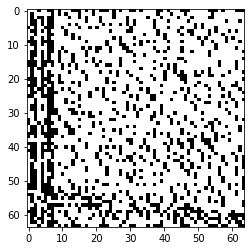

In [250]:
extracted_RONI_watermark = extract_RONI(reconstrcuted_RONI)
plt.imshow(extracted_RONI_watermark,cmap="gray")

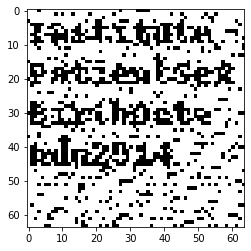

In [251]:
RONI_decrypted_watermark = arnold_transform_reverse(extracted_RONI_watermark, N)
plt.imshow(RONI_decrypted_watermark,cmap="gray")

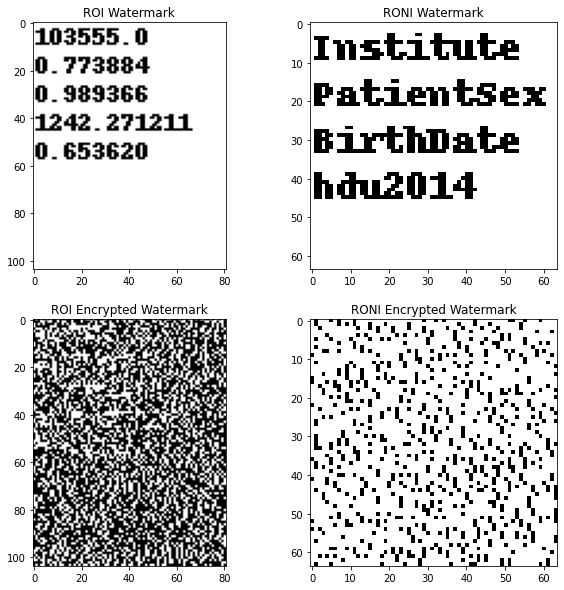

In [252]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(ROI_watermark, cmap="gray")
axs[0, 0].set_title("ROI Watermark")
axs[1, 0].imshow(ROI_encrypted_watermark, cmap="gray")
axs[1, 0].set_title("ROI Encrypted Watermark")
axs[0, 1].imshow(RONI_watermark, cmap="gray")
axs[0, 1].set_title("RONI Watermark")
axs[1, 1].imshow(RONI_encrypted_watermark, cmap="gray")
axs[1, 1].set_title("RONI Encrypted Watermark")
plt.show()

# Attacks

## Salt and Pepper Noise

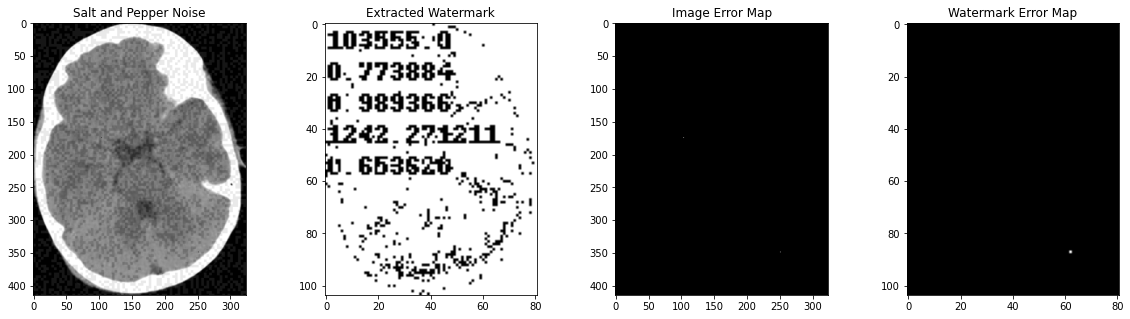

In [253]:
def add_salt_pepper_noise(X_img):
    X_img_copy = X_img.copy()
    row, col = X_img_copy.shape
    salt_vs_pepper = 0.5
    amount = 0.01
    num_salt = np.ceil(amount * X_img_copy.size * salt_vs_pepper * 0.0001)
    num_pepper = np.ceil(amount * X_img_copy.size * (1.0 - salt_vs_pepper) * 0.0001)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
    X_img_copy[coords[0], coords[1]] = 1
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
    X_img_copy[coords[0], coords[1]] = 0
    return X_img_copy

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
salt_pepper_noise_imgs = add_salt_pepper_noise(image)
axs[0].set_title("Salt and Pepper Noise")
axs[0].imshow(salt_pepper_noise_imgs,cmap="gray")
extracted_watermark = extract_ROI_watermark(salt_pepper_noise_imgs, boolean_x)
axs[1].set_title("Extracted Watermark")
axs[1].imshow(extracted_watermark,cmap="gray")
image_error_map = salt_pepper_noise_imgs.astype("int") ^ image.astype("int")
axs[2].set_title("Image Error Map")
axs[2].imshow(image_error_map,cmap="gray")
watermark_error_map = extracted_ROI_watermark.astype("int") ^ extracted_watermark.astype("int")
axs[3].set_title("Watermark Error Map")
axs[3].imshow(watermark_error_map,cmap="gray")

## Gaussian Noise

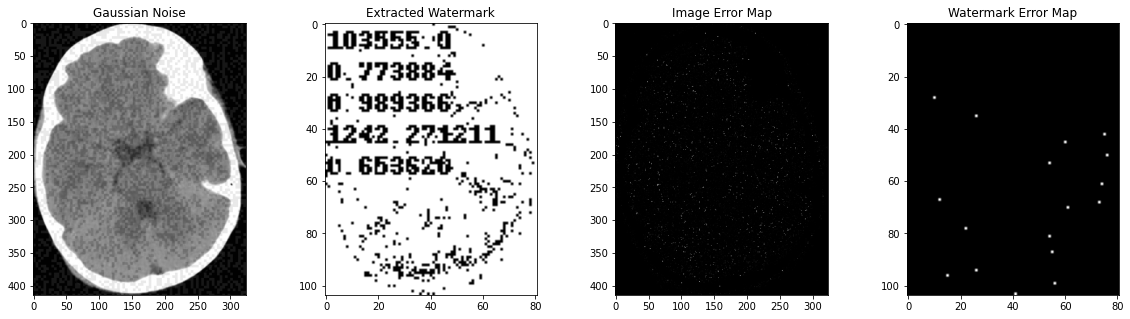

In [254]:
def add_gaussian_noise(image):
    return np.random.normal(0,0.1**0.5,image.shape) + image

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
gaussian_noise_img = add_gaussian_noise(image)
axs[0].set_title("Gaussian Noise")
axs[0].imshow(gaussian_noise_img,cmap="gray")
extracted_watermark = extract_ROI_watermark(gaussian_noise_img, boolean_x)
axs[1].set_title("Extracted Watermark")
axs[1].imshow(extracted_watermark,cmap="gray")
image_error_map = gaussian_noise_img.astype("int") ^ image.astype("int")
axs[2].set_title("Image Error Map")
axs[2].imshow(image_error_map,cmap="gray")
watermark_error_map = extracted_ROI_watermark.astype("int") ^ extracted_watermark.astype("int")
axs[3].set_title("Watermark Error Map")
axs[3].imshow(watermark_error_map,cmap="gray")

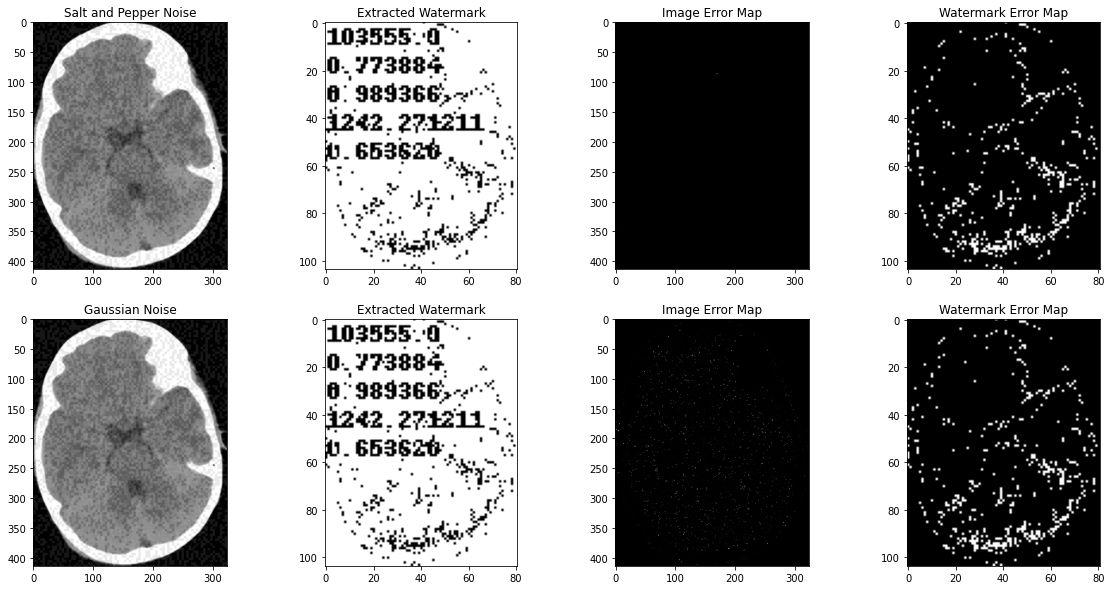

In [255]:
attack_dict = {
    "Salt and Pepper Noise" : add_salt_pepper_noise,
    "Gaussian Noise" : add_gaussian_noise,
}
fig, axs = plt.subplots(len(attack_dict), 4, figsize=(20, 5*len(attack_dict)))
attacks_df = pd.DataFrame(columns = ['Attack', 'MSE', 'PSNR','SSIM'])

def apply_attacks(image, watermark, watermark_extraction_func, attack_dict, df):
    attacks = list(attack_dict.items())
    for i in range(len(attacks)):
        modified_image = attacks[i][1](image)
        axs[i,0].set_title(f"{attacks[i][0]}")
        axs[i,0].imshow(modified_image,cmap="gray")
        
        extracted_watermark = watermark_extraction_func(modified_image,boolean_x)
        axs[i,1].set_title("Extracted Watermark")
        axs[i,1].imshow(extracted_watermark,cmap="gray")
        
        image_error_map = image.copy().astype("int")^modified_image.copy().astype("int")
        axs[i,2].set_title("Image Error Map")
        axs[i,2].imshow(image_error_map,cmap="gray")
        
        watermark_error_map = watermark.copy().astype("int")^extracted_watermark.copy().astype("int")
        axs[i,3].set_title("Watermark Error Map")
        axs[i,3].imshow(watermark_error_map,cmap="gray")
        mse = MSE(watermark, extracted_watermark)
        psnr = PSNR(watermark, extracted_watermark)
        ssim = SSIM(watermark, extracted_watermark)
        df.loc[i] = [attacks[i][0], mse, psnr, ssim]
    return df
        
attacks_df = apply_attacks(image,ROI_watermark, extract_ROI_watermark, attack_dict, attacks_df)

In [256]:
attacks_df

,Attack,MSE,PSNR,SSIM
0,Salt and Pepper Noise,0.056387,12.488247,0.549845
1,Gaussian Noise,0.058286,12.344369,0.533835


## Compiled

In [391]:
square = np.array([[1,1,1], [1,1,1], [1,1,1]])

def process_image(file_name):
    img = imread(f'./images/{file_name}')
    return img.astype("float")

def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im

def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im

def generate_threshold_mask(img):
    threshold = threshold_otsu(img)
    result = (img > threshold)
    multi_dilated = multi_dil(result, 7)
    area_closed = area_closing(multi_dilated, 50000)
    multi_eroded = multi_ero(area_closed, 7)
    opened = opening(multi_eroded)
    return opened

def extract_region_features(binarized):
    label_im = label(binarized)
    regions = regionprops(label_im)
    properties = ['area','bbox_area',
              'solidity', 'eccentricity','perimeter']
    table = pd.DataFrame(regionprops_table(label_im, binarized, properties=properties))
    table["area_ratio"] = table["area"] / table["bbox_area"]
    return (table, regions)
# ------------------------------ ROI --------------------------------

def extract_ROI(table, regions, img):
    ROI_index = table["area"].idxmax()
    box = regions[ROI_index].bbox
    return (box,ROI_index)

def extract_ROI_region(filename):
    with open(f"./images/{filename}.json","r") as file:
        coords = json.load(file)
    box = coords["ROI"]
    return box

def process_coefficients(imArray, model, level):
    coeffs=pywt.wavedec2(data = imArray, wavelet = model, level = level)
    coeffs_H=(coeffs)
    return coeffs_H

def quantization_step(LH2, HL2, HH2, k):
    LH2 = np.absolute(LH2).sum()
    HL2 = np.absolute(HL2).sum()
    HH2 = np.absolute(HH2).sum()
    return k * round(math.log((LH2 + HL2 + HH2) / 2))

def DWT(ROI, model, level, k):
    coeffs_image = process_coefficients(ROI, model, level=level)
    LL2 , (LH2, HL2, HH2), (LH1, HL1, HH1) = coeffs_image
    Q = quantization_step(LH2, HL2, HH2, k)
    print(Q)
    Xq = LL2 / Q
    return Xq, (LH2, HL2, HH2), (LH1, HL1, HH1), Q

def ROI_watermark_generation(height, width, table, index):
    watermark = Image.new("RGB",(width,height),color=(255,255,255))
    area = table.iloc[index].area
    area_ratio = table.iloc[index].area_ratio
    solidity = table.iloc[index].solidity
    perimeter = table.iloc[index].perimeter
    eccentricity = table.iloc[index].eccentricity
    area_ratio_str = "{:.6f}".format(area_ratio)
    solidity_str = "{:.6f}".format(solidity)
    perimeter_str = "{:.6f}".format(perimeter)
    eccentricity_str = "{:.6f}".format(eccentricity)
    watermark_text = f"{area}\n{area_ratio_str}\n{solidity_str}\n{perimeter_str}\n{eccentricity_str}"
    watermark_draw = ImageDraw.Draw(watermark)
    watermark_draw.multiline_text((1,1),watermark_text,spacing=1,fill=(0,0,0))
    watermark_array = np.asarray(watermark)
    watermark = rgb2gray(watermark_array)
    return watermark

def ROI_watermark_encryption(watermark):
    row, col = watermark.shape
    N = row * col
    x = 0.9 + np.zeros(N)
    r = 3.95
    for n in range(N-1):
        x[n+1] = r * x[n] * (1 - x[n])
    x = x.reshape(row, col)
    boolean_x = np.around(x).astype("int")
    watermark = watermark.astype("int")
    encrypted_watermark = np.bitwise_xor(watermark, boolean_x).astype("float")
    return encrypted_watermark, boolean_x

def ROI_watermark_embed(Xq, ROI_encrypted_watermark, Q ):
    Xq_copy = Xq.copy()
    row, col = Xq_copy.shape
    for i in range(row):
        for j in range(col):
            if(round(Xq[i,j]%2) == ROI_encrypted_watermark[i,j]):
                Xq_copy[i,j] = Xq[i,j] * Q
            else:
                Xq_copy[i,j] = (Xq[i,j] * Q) + Q
    return Xq_copy

def extract_ROI_watermark(image,boolean_x, model, level, k):
    Zq, (LH2, HL2, HH2), (LH1, HL1, HH1), Q = DWT(image, model, level, k)
    Zq = np.round(Zq)
    Wsroi = Zq%2
    Wroi_salt = Wsroi.copy().astype("int")^boolean_x
    return Wroi_salt.astype("float")

# --------------------------------- RONI --------------------------------

def extract_RONI_region(filename):
    with open(f"./images/{filename}.json","r") as file:
        coords = json.load(file)
    box = coords["RONI"]
    return box

def extract_capacity(filename):
    with open(f"./images/{filename}.json","r") as file:
        coords = json.load(file)
    capacity = coords["capacity"]
    return capacity

def RONI_watermark_generation(capacity):
    RONI_watermark = Image.new("RGB",(capacity,capacity),color=(255,255,255))
    RONI_watermark_text = f"Institute\nPatientSex\nBirthDate\nhdu2014"
    RONI_watermark_draw = ImageDraw.Draw(RONI_watermark)
    RONI_watermark_draw.multiline_text((1,1),RONI_watermark_text,spacing=1,fill=(0,0,0))
    RONI_watermark_array = np.asarray(RONI_watermark)
    RONI_watermark = rgb2gray(RONI_watermark_array)
    return RONI_watermark

def arnold_transform(watermark):
    A = np.array([[1,1],[1,2]])
    watermark_copy = watermark
    N = 10
    for n in range(0,N):
        watermark_final = np.zeros(watermark_copy.shape)
        for i in range(watermark_copy.shape[0]):
            for j in range(watermark_copy.shape[1]):
                x = np.array([[i],[j]])
                y = np.matmul(A,x) % watermark_copy.shape[0]
                watermark_final[y[0][0], y[1][0]] = watermark_copy[i,j]
        watermark_copy = watermark_final
    return watermark_final, N

def arnold_transform_reverse(watermark, N):
    A = np.array([[2,-1],[-1,1]])
    watermark_final = watermark
    for n in range(0,N):
        watermark_copy = np.zeros(watermark_final.shape)
        for i in range(watermark_copy.shape[0]):
            for j in range(watermark_copy.shape[1]):
                x = np.array([[i],[j]])
                y = np.matmul(A,x) % watermark_copy.shape[0]
                watermark_copy[y[0][0], y[1][0]] = watermark_final[i,j]
        watermark_final = watermark_copy
    return watermark_final

def extract_blocks(RONI):
    block_size=8
    i = 0
    RONI_blocks = np.empty((int(RONI.shape[0]/8), int( RONI.shape[1]/8), 8, 8), dtype="uint8")
    for r in range(0,RONI.shape[0], block_size):
        for c in range(0,RONI.shape[1], block_size):
            window = RONI[r:r+block_size ,c:c+block_size]
            RONI_blocks[int(r/8),int(c/8)] = window
    return RONI_blocks

def reconstruct_blocks(RONI_blocks):
    block_size=8
    reconstructed_RONI = np.empty((RONI_blocks.shape[0]*8,RONI_blocks.shape[1]*8))
    for r in range(0,RONI.shape[0], block_size):
        for c in range(0,RONI.shape[1], block_size):
            reconstructed_RONI[r:r+block_size ,c:c+block_size] = RONI_blocks[int(r/8),int(c/8)]
    return reconstructed_RONI

def zigzag(n):
    '''zigzag rows'''
    def compare(xy):
        x, y = xy
        return (x + y, -y if (x + y) % 2 else y)
    xs = range(n)
    return {index: n for n, index in enumerate(sorted(
        ((x, y) for x in xs for y in xs),
        key=compare
    ))}

def embed_RONI_watermark(img,zigzag_pattern,watermark_bits):
    DCT = dct(img,norm="ortho")
    zigzag_dct = np.empty(64)
    Q = 4
    for i in range(0,64):
        zigzag_dct[i] = DCT[zigzag_pattern[i][0], zigzag_pattern[i][1]]
    middle_frequency = zigzag_dct[12:20]
    middle_frequency = np.round(middle_frequency / Q)
    embedded_frequency = np.empty(len(middle_frequency))
    for i in range(len(middle_frequency)):
        if((middle_frequency[i] + watermark_bits[i])%2 == 0):
            embedded_frequency[i] = (middle_frequency[i] + 0.5)*Q
        elif((middle_frequency[i] + watermark_bits[i])%2 == 1):
            embedded_frequency[i] = (middle_frequency[i] - 0.5)*Q
    zigzag_dct[12:20] = embedded_frequency
    inverse_zigzag = np.empty((8,8))
    for i in range(0,64):
        inverse_zigzag[zigzag_pattern[i][0],zigzag_pattern[i][1]] = zigzag_dct[i]
    return np.round(np.absolute(idct(inverse_zigzag)))

def embed_RONI(RONI_blocks,RONI_encrypted_watermark):
    watermark_bit_count = 0
    watermark = RONI_encrypted_watermark.copy().flatten()
    zigzag_pattern = list(zigzag(8).keys())
    embedded_RONI_blocks = np.empty(RONI_blocks.shape)
    for i in range(0,RONI_blocks.shape[0]):
        for j in range(0,RONI_blocks.shape[1]):
            watermark_bits = watermark[watermark_bit_count:watermark_bit_count+8]
            embedded_RONI_blocks[i,j] = embed_RONI_watermark(RONI_blocks[i,j],zigzag_pattern,watermark_bits)
            watermark_bit_count+=8
    return embedded_RONI_blocks

def extract_RONI_watermark(img,zigzag_pattern):
    Q = 4
    zigzag_dct = np.empty(64)
    for i in range(0,64):
        zigzag_dct[i] = dct(img)[zigzag_pattern[i][0],zigzag_pattern[i][1]]
    return np.floor(zigzag_dct[12:20] / Q) % 2

def extract_RONI(embedded_RONI, capacity):
    extracted_watermark = np.empty(capacity*capacity)
    watermark_bit_count = 0
    embedded_RONI_blocks = extract_blocks(embedded_RONI)
    zigzag_pattern = list(zigzag(8).keys())
    for i in range(0,embedded_RONI_blocks.shape[0]):
        for j in range(0,embedded_RONI_blocks.shape[1]):
            watermark_bits = extract_RONI_watermark(embedded_RONI_blocks[i,j], zigzag_pattern)
            extracted_watermark[watermark_bit_count:watermark_bit_count+8] = watermark_bits
            watermark_bit_count+=8
    return np.reshape(extracted_watermark,(-1,capacity))

# -------------------------- MAIN ---------------------------------------

def embedding(filename):
    level = 2
    model = "haar"
    k = 8
    capacity=extract_capacity(filename)
    image_array = process_image(f"{filename}.png")
    binarized = generate_threshold_mask(image_array)
    table, regions = extract_region_features(binarized)
    ROI__cords, ROI_index = extract_ROI(table, regions, image_array)
    ROI = image_array[ROI__cords[0]:ROI__cords[2],ROI__cords[1]:ROI__cords[3]]
    Xq, (LH2, HL2, HH2), (LH1, HL1, HH1), Q = DWT(ROI, model, level, k)
    watermark_height, watermark_width = Xq.shape
    watermark = ROI_watermark_generation(watermark_height, watermark_width, table, ROI_index)
    encrypted_watermark, boolean_x = ROI_watermark_encryption(watermark)
    Xq_copy = ROI_watermark_embed(Xq,encrypted_watermark, Q)
    coeffs = [Xq_copy, (LH2,HL2, HH2), (LH1, HL1, HH1)]
    embedded_ROI = pywt.waverec2(coeffs, model)
    embedded_ROI = np.round(np.absolute(embedded_ROI))
    
    RONI_coords = extract_RONI_region(filename)
    RONI = image_array[RONI_coords["0"]:RONI_coords["2"], RONI_coords["1"]:RONI_coords["3"]]
    RONI_watermark = RONI_watermark_generation(capacity)
    RONI_encrypted_watermark, N = arnold_transform(RONI_watermark)
    RONI_blocks = extract_blocks(RONI)
    embedded_RONI_blocks = embed_RONI(RONI_blocks,RONI_encrypted_watermark)
    reconstrcuted_RONI = reconstruct_blocks(embedded_RONI_blocks)
    
    image_array[ROI__cords[0]:ROI__cords[2],ROI__cords[1]:ROI__cords[3]] = np.delete(embedded_ROI, embedded_ROI.shape[0]-1,0)
    image_array[RONI_coords["0"]:RONI_coords["2"], RONI_coords["1"]:RONI_coords["3"]] = reconstrcuted_RONI
    return image_array, boolean_x

def extracting(filename, image, boolean_x):
    level = 2
    model = "haar"
    k = 8
    capacity=extract_capacity(filename)
    ROI_coords = extract_ROI_region(filename)
    ROI = image[ROI_coords["0"]:ROI_coords["2"],ROI_coords["1"]:ROI_coords["3"]]
    extracted_ROI_watermark = extract_ROI_watermark(ROI,boolean_x, model, level, k)
    
    RONI_coords = extract_RONI_region(filename)
    RONI = image[RONI_coords["0"]:RONI_coords["2"], RONI_coords["1"]:RONI_coords["3"]]
    extracted_RONI_watermark = extract_RONI(RONI,capacity)
    RONI_decrypted_watermark = arnold_transform_reverse(extracted_RONI_watermark, N)
    return extracted_ROI_watermark, RONI_decrypted_watermark

96


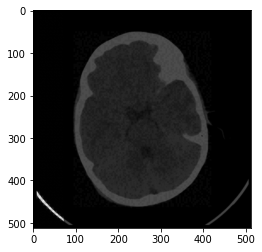

In [399]:
result, boolean_x = embedding("brain")
plt.imshow(result,cmap="gray")

In [401]:
 extracted_ROI_watermark, RONI_decrypted_watermark = extracting("brain", result, boolean_x)

96


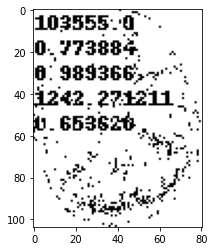

In [402]:
plt.imshow(extracted_ROI_watermark, cmap="gray")

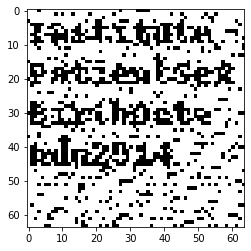

In [403]:
plt.imshow(RONI_decrypted_watermark, cmap="gray")